<a href="https://colab.research.google.com/github/sankeawthong/Project-1-Lita-Chatbot/blob/main/%5B20250116%5D%20FedAvg-DL%20with%20MLP-LSTM%20model%20on%20NF-ToN-IoT%20with%20early%20stopped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**FedAvg-DL // MLP-LSTM model 10 classes on NF-ToN-IoT**

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder, StandardScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Bidirectional, Dropout, Flatten
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from keras.utils import to_categorical

In [ ]:
# Load dataset
dataset = pd.read_csv("Dataset_NF-ToN-IoT.csv") #NF-ToN-IoT 10 classes dataset

# Preprocessing: Handle missing values (if any)
dataset = dataset.dropna() # Remove missing values

In [ ]:
dataset

,L4_SRC_PORT,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack,Class
0,63318,443,6,91.00,181,165,2,1,24,327,0,Benign,0
1,57442,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
2,57452,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
3,138,138,17,10.16,472,0,2,0,0,0,0,Benign,0
4,51989,15600,17,0.00,63,0,1,0,0,0,0,Benign,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048570,443,54560,6,91.00,52,52,1,1,17,15,0,Benign,0
1048571,443,54594,6,91.00,52,52,1,1,17,11,0,Benign,0
1048572,443,54582,6,91.00,52,52,1,1,17,11,0,Benign,0
1048573,443,54592,6,91.00,52,52,1,1,17,11,0,Benign,0


**Data Preprocessing**

In [ ]:
# Encode non-numeric columns (if any)
for column in dataset.columns:
    if dataset[column].dtype == 'object':  # Identify categorical columns
        dataset[column] = LabelEncoder().fit_transform(dataset[column])

# Separate features (X) and target (y)
X = dataset.drop(['Class'], axis=1)  # Assuming 'Class' is the target column
y = dataset['Class']

In [ ]:
print("Original Class Distribution:", np.bincount(y))

Original Class Distribution: [164866  17243 149605  10732 453506   1249 135353    142  15966  99913]


In [ ]:
# Standardize the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [ ]:
!pip install -U imbalanced-learn

**Data Balancing utilized SMOTE**

In [ ]:
from imblearn.over_sampling import SMOTE
# Balance dataset using SMOTE
smote = SMOTE(random_state=42)
X, y = smote.fit_resample(X, y)

# Verify the balanced dataset distribution
print("Balanced Class Distribution:", np.bincount(y))

Balanced Class Distribution: [453506 453506 453506 453506 453506 453506 453506 453506 453506 453506]


**Split data into 80% Training and 20% Testing**

In [ ]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101, stratify=y)

**The hybrid MLP + LSTM model**

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Flatten, TimeDistributed, InputLayer
from keras.regularizers import l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping

# Convert target to categorical (one-hot encoding)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

# Reshape the input data for LSTM compatibility
# Assuming the input features need to be reshaped into a 3D array: (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

# Define the hybrid MLP + LSTM model with regularization
def build_hybrid_model(input_shape, num_classes):
    model = Sequential()

    # Input Layer
    model.add(InputLayer(input_shape=input_shape))

    # LSTM Layer
    model.add(LSTM(64, activation='tanh', return_sequences=False, kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # MLP Layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))  # Dropout for regularization

    # Output Layer
    model.add(Dense(num_classes, activation='softmax'))

    return model

# Build and compile the model
input_shape = (X_train.shape[1], X_train.shape[2])  # Adjusted for LSTM input format
num_classes = y_train.shape[1]
model = build_hybrid_model(input_shape, num_classes)
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Train the model with early stopping
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = model.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Epoch 1/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 839s 7ms/step - accuracy: 0.9564 - loss: 0.2913 - val_accuracy: 0.9967 - val_loss: 0.1056
Epoch 2/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 862s 8ms/step - accuracy: 0.9848 - loss: 0.1324 - val_accuracy: 0.9988 - val_loss: 0.0807
Epoch 3/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 852s 8ms/step - accuracy: 0.9865 - loss: 0.1190 - val_accuracy: 0.9981 - val_loss: 0.0847
Epoch 4/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 860s 8ms/step - accuracy: 0.9870 - loss: 0.1142 - val_accuracy: 0.9967 - val_loss: 0.0846
Epoch 5/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 858s 8ms/step - accuracy: 0.9874 - loss: 0.1097 - val_accuracy: 0.9975 - val_loss: 0.0808
Epoch 6/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 851s 8ms/step - accuracy: 0.9876 - loss: 0.1083 - val_accuracy: 0.9979 - val_loss: 0.0798
Epoch 7/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 848s 7ms/step - accuracy: 0.9875 - loss: 0.1068 - val_accuracy: 0.9947 - val_loss: 0.0722
Epoch 8/50
113377/113377 ━━━━━━━━━━━━━━━━━━━━ 82

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score
# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

Accuracy: 0.9987100501
Precision: 0.9987164753
Recall: 0.9987100501
F1-Score: 0.9987101365


In [ ]:
# Evaluate the model
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Metrics
accuracy = accuracy_score(y_true_classes, y_pred_classes)
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

print("Accuracy: {:.10f}".format(accuracy))
print("Precision: {:.10f}".format(precision))
print("Recall: {:.10f}".format(recall))
print("F1-Score: {:.10f}".format(f1))

28345/28345 ━━━━━━━━━━━━━━━━━━━━ 47s 2ms/step
Accuracy: 0.9987100501
Precision: 0.9987164753
Recall: 0.9987100501
F1-Score: 0.9987101365


In [ ]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print("Confusion Matrix:\n", conf_matrix)

Confusion Matrix:
 [[90698     1     1     1     0     0     0     0     0     0]
 [    0 89990   712     0     0     0     0     0     0     0]
 [    0     2 90685    14     0     0     0     0     0     0]
 [    0     0    26 90675     0     0     0     0     0     0]
 [    1     0     0     0 90700     0     0     0     0     0]
 [    0     0     0     0     7 90530   164     0     0     0]
 [    0     0     0     0     0   224 90470     0     8     0]
 [    0     0     0     0     0     0     0 90701     0     0]
 [    0     0     0     0     0     0     0     0 90692     9]
 [    0     0     0     0     0     0     0     0     0 90701]]


In [ ]:
# Detection Rate (Recall for each class)
print("Detection Rates per Class:", recall_score(y_true_classes, y_pred_classes, average=None))

Detection Rates per Class: [0.99996692 0.99215012 0.9998236  0.99971334 0.99998897 0.99811468
 0.99744217 1.         0.99990077 1.        ]


In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
# Import roc_curve
from sklearn.metrics import roc_curve # This line imports the roc_curve function
from sklearn.metrics import auc # This line imports the auc function
import matplotlib.pyplot as plt # Import the pyplot module from matplotlib as plt

# After training, calculate ROC curves and AUC for each class
n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves
plt.figure(figsize=(10, 8))
colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))

for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} (AUC = {1:0.10f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves')
plt.legend(loc="lower right")

# Save the plot as a high-resolution image
plt.savefig('roc_curves.png', dpi=300, bbox_inches='tight')
plt.close()

# Calculate and print AUC scores for each class
print("\nAUC Scores for each class:")
for i in range(n_classes):
    print(f"Class {i}: {roc_auc[i]:.10f}")

# Calculate macro-average AUC
macro_roc_auc = np.mean(list(roc_auc.values()))
print(f"\nMacro-average AUC: {macro_roc_auc:.10f}")

<ipython-input-15-c5170017384f>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('Set1')(np.linspace(0, 1, n_classes))



AUC Scores for each class:
Class 0: 0.9999997498
Class 1: 0.9999986798
Class 2: 0.9999918534
Class 3: 0.9999911023
Class 4: 0.9999921688
Class 5: 0.9999941215
Class 6: 0.9999918757
Class 7: 1.0000000000
Class 8: 0.9999962106
Class 9: 1.0000000000

Macro-average AUC: 0.9999955762


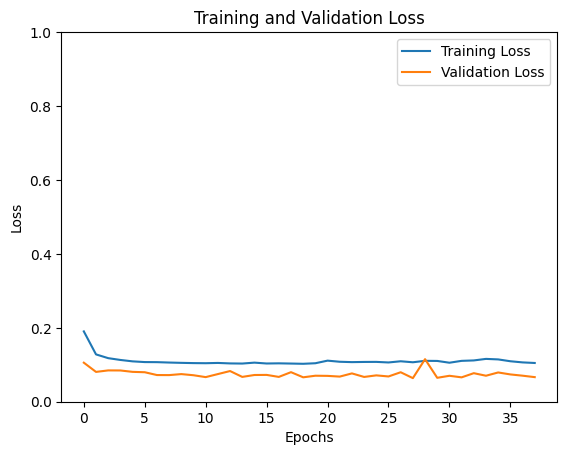

In [ ]:
# Plot Training and Validation Loss
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim(0, 1)  # Set y-axis scale to 1
plt.legend()
plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import itertools
import seaborn as sns
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
def conf_mat(d1,d2):
  cm = confusion_matrix(d1, d2)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="PuBu",
                 vmin=0, vmax=35000, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=1)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ##plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  ##plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Hybrid RF-LSTM Model


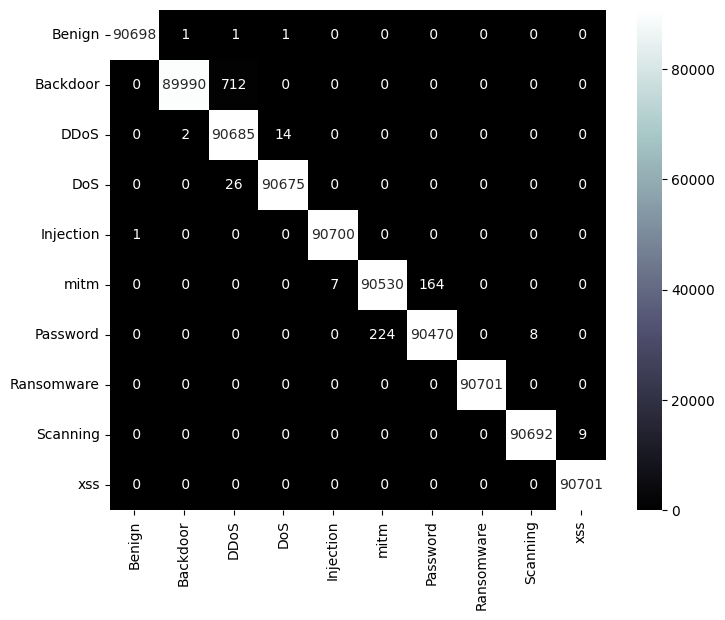

In [ ]:
print("Confusion Matrix of Hybrid RF-LSTM Model")
#conf_mat(np.argmax(y_test, axis=1), test_rf_lstm_predictions)
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(8,6.5))
# Use plt.xticks to set custom tick labels
# Using get_xticklabels() to access the current labels and then setting rotation.
plt.xticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
plt.yticks(ticks=np.arange(10), labels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], rotation=45)
sns.heatmap(conf_matrix, annot=True, fmt='2', cmap='bone',xticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'], yticklabels=['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
sns.set(font_scale=1)
plt.show() # Display the heatmap

In [ ]:
def conf_mat(d1,d2):
  cm = confusion_matrix(y_true_classes, y_pred_classes)
  #plt.figure(figsize=(6,5.5))
  plt.figure(figsize=(8,6.5))
  #ax = sns.heatmap(cm,  fmt='2', annot=True, cmap='tab20c')
  ax = sns.heatmap(cm, annot=True, fmt=".0f", cmap="gist_yarg",
                 vmin=0, vmax=5600, center=0, square=True, linewidths=1.5)
  sns.set(font_scale=0.85)
  ax.set_xlabel('\nPredicted Values')
  ax.set_ylabel('Actual Values\n');
  ax.xaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  ax.yaxis.set_ticklabels(['Benign','Backdoor','DDoS','DoS','Injection','mitm','Password','Ransomware','Scanning','xss'])
  plt.xticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.yticks(rotation=45)  # Add this line to rotate the x-axis labels by 45 degrees
  plt.tight_layout()
  # plt.savefig("F1.eps", format = 'eps')
  plt.show()

Confusion Matrix of Federated DL// MLP-LSTM Model


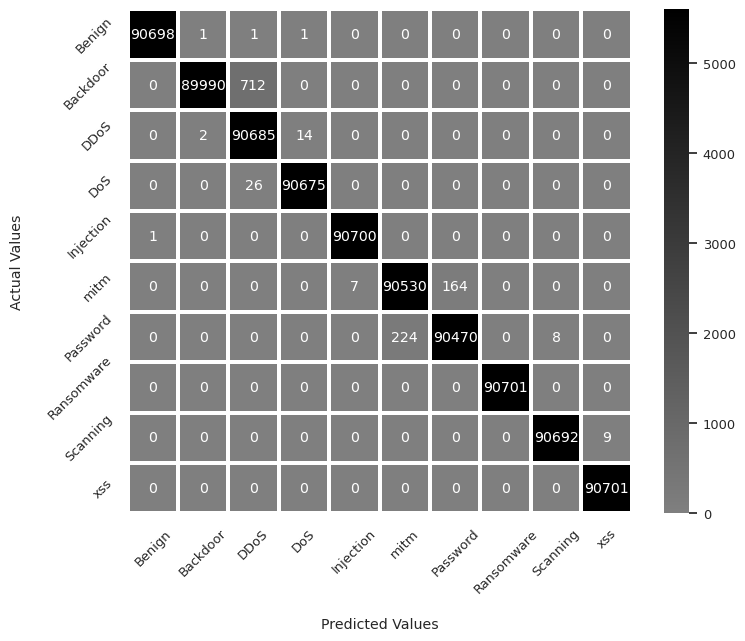

In [ ]:
print("Confusion Matrix of Federated DL// MLP-LSTM Model")
conf_mat(y_true_classes, y_pred_classes)

**Federated Learning Simulation (FedAvg)**

In [ ]:
# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    # Split training data among clients
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    # Initialize the global model
    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the global model
    global_weights = global_model.get_weights()

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])  # Compile the local model

            # Train the local model
            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"Round {round + 1}: Global Model Accuracy = {acc:.10f}")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Round 1: Global Model Accuracy = 0.4976769984
Round 2: Global Model Accuracy = 0.9891974926
Round 3: Global Model Accuracy = 0.9930772781
Round 4: Global Model Accuracy = 0.9939284325
Round 5: Global Model Accuracy = 0.9930122495
Round 6: Global Model Accuracy = 0.9909372926
Round 7: Global Model Accuracy = 0.9942073822
Round 8: Global Model Accuracy = 0.9941224456
Round 9: Global Model Accuracy = 0.9934411049
Round 10: Global Model Accuracy = 0.9927806854


In [ ]:
import time
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# Function to measure model performance
def evaluate_global_model(global_model, X_test, y_test):
    y_pred = global_model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(y_test, axis=1)

    # Compute performance metrics
    accuracy = accuracy_score(y_true_classes, y_pred_classes)
    precision = precision_score(y_true_classes, y_pred_classes, average='weighted')
    recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
    f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    print("\nModel Performance Metrics:")
    print(f"Accuracy: {accuracy:.10f}")
    print(f"Precision: {precision:.10f}")
    print(f"Recall: {recall:.10f}")
    print(f"F1-Score: {f1:.10f}")
    print("\nConfusion Matrix:")
    print(cm)

    return accuracy, precision, recall, f1

# Function to analyze communication overhead
def analyze_communication_overhead(local_weights, global_weights):
    communication_cost = 0
    for i in range(len(local_weights)):
        # Compute the size of weights transmitted between clients and server
        communication_cost += sum(w.nbytes for w in local_weights[i])
    communication_cost += sum(w.nbytes for w in global_weights)

    print(f"\nCommunication Overhead: {communication_cost / (1024 ** 2):.2f} MB")  # in megabytes

# Federated Learning Simulation (FedAvg)
def federated_learning_simulation(X_train, y_train, X_test, y_test, num_clients=5):
    client_data = np.array_split(X_train, num_clients)
    client_labels = np.array_split(y_train, num_clients)

    global_model = build_hybrid_model(input_shape, num_classes)
    global_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    global_weights = global_model.get_weights()

    communication_overhead = []
    latency_per_round = []

    for round in range(10):  # Simulate 10 communication rounds
        local_weights = []

        start_time = time.time()  # Start measuring latency

        for i in range(num_clients):
            local_model = build_hybrid_model(input_shape, num_classes)
            local_model.set_weights(global_weights)
            local_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

            local_model.fit(client_data[i], client_labels[i], epochs=1, batch_size=32, verbose=0)
            local_weights.append(local_model.get_weights())

        # Aggregate weights (FedAvg)
        global_weights = [
            np.mean([local_weights[j][i] for j in range(num_clients)], axis=0)
            for i in range(len(global_weights))
        ]
        global_model.set_weights(global_weights)

        # Measure latency
        end_time = time.time()
        latency = end_time - start_time
        latency_per_round.append(latency)

        # Measure communication overhead
        analyze_communication_overhead(local_weights, global_weights)

        # Evaluate the global model
        loss, acc = global_model.evaluate(X_test, y_test, verbose=0)
        print(f"\nRound {round + 1}: Global Model Accuracy = {acc:.10f}")

        # Evaluate model performance metrics
        evaluate_global_model(global_model, X_test, y_test)

    # Summarize overall latency
    print("\nLatency Analysis:")
    print(f"Average Latency per Round: {np.mean(latency_per_round):.2f} seconds")
    print(f"Total Latency for 10 Rounds: {np.sum(latency_per_round):.2f} seconds")

# Call the federated learning simulation function
federated_learning_simulation(X_train, y_train, X_test, y_test)


Communication Overhead: 0.78 MB

Round 1: Global Model Accuracy = 0.5470489860
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 50s 2ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Model Performance Metrics:
Accuracy: 0.5470489916
Precision: 0.5326443384
Recall: 0.5470489916
F1-Score: 0.4681999788

Confusion Matrix:
[[65611 24477   613     0     0     0     0     0     0     0]
 [    0 37329 53373     0     0     0     0     0     0     0]
 [    0 50541 28093     0 12067     0     0     0     0     0]
 [    0     3     0     0 90698     0     0     0     0     0]
 [    0     0     0     0 87724  2977     0     0     0     0]
 [    0     0     0     0  1831 86761  2076    33     0     0]
 [    0     0     0     0     0     1  5082 80624  4995     0]
 [    0     0     0     0     0     0     0 90400   129   172]
 [    0     0     0     0     0     0     0 21634  4479 64588]
 [    0     0     0     0     0     0     0     0     0 90701]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 2: Global Model Accuracy = 0.9940452576
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 52s 2ms/step

Model Performance Metrics:
Accuracy: 0.9940452828
Precision: 0.9940969239
Recall: 0.9940452828
F1-Score: 0.9940443696

Confusion Matrix:
[[90697     4     0     0     0     0     0     0     0     0]
 [    0 89929   773     0     0     0     0     0     0     0]
 [    0    33 90667     0     0     0     0     1     0     0]
 [    0     0    28 90673     0     0     0     0     0     0]
 [    0     0     0  2317 88382     2     0     0     0     0]
 [    0     0     0     0  1419 89218    58     6     0     0]
 [    0     0     0     0     0   221 90453    28     0     0]
 [    0     0     0     0     0     0   368 90225   108     0]
 [    0     0     0     0     0     0     0     1 90666    34]
 [    0     0     0     0     0     0     0     0     0 90701]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 3: Global Model Accuracy = 0.9944399595
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 54s 2ms/step

Model Performance Metrics:
Accuracy: 0.9944399854
Precision: 0.9945864211
Recall: 0.9944399854
F1-Score: 0.9944409640

Confusion Matrix:
[[90697     4     0     0     0     0     0     0     0     0]
 [    0 89954   748     0     0     0     0     0     0     0]
 [    1    37 90662     1     0     0     0     0     0     0]
 [    0     0    28 90673     0     0     0     0     0     0]
 [    0     0     0     0 90690    11     0     0     0     0]
 [    0     0     0     0    37 90531    97    36     0     0]
 [    0     0     0     0     0   243 90432    27     0     0]
 [    0     0     0     0     0     0   274 90315   112     0]
 [    0     0     0     0     0     0     0     0 90677    24]
 [    0     0     0     0     0     0     0     0  3363 87338]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 4: Global Model Accuracy = 0.9946009517
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 59s 2ms/step

Model Performance Metrics:
Accuracy: 0.9946009535
Precision: 0.9947416555
Recall: 0.9946009535
F1-Score: 0.9945999451

Confusion Matrix:
[[90698     3     0     0     0     0     0     0     0     0]
 [    0 89956   746     0     0     0     0     0     0     0]
 [    0    12 90688     0     0     0     0     1     0     0]
 [    0     0    28 90673     0     0     0     0     0     0]
 [    0     0     0     0 90685    16     0     0     0     0]
 [    0     0     0     0     0 90636    54    11     0     0]
 [    0     0     0     0     0   224 90472     6     0     0]
 [    0     0     0     0     0     0   428 90273     0     0]
 [    0     0     0     0     0     0     0     0 90694     7]
 [    0     0     0     0     0     0     0     0  3361 87340]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 5: Global Model Accuracy = 0.9949240088
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 70s 2ms/step

Model Performance Metrics:
Accuracy: 0.9949239922
Precision: 0.9950604234
Recall: 0.9949239922
F1-Score: 0.9949227906

Confusion Matrix:
[[90698     3     0     0     0     0     0     0     0     0]
 [    0 89976   726     0     0     0     0     0     0     0]
 [    1     9 90691     0     0     0     0     0     0     0]
 [    0     0     0 90673    28     0     0     0     0     0]
 [    0     0     0     0 90676    25     0     0     0     0]
 [    0     0     0     0     6 90659    25    11     0     0]
 [    0     0     0     0     0   236 90466     0     0     0]
 [    0     0     0     0     0     0   168 90533     0     0]
 [    0     0     0     0     0     0     0     1 90681    19]
 [    0     0     0     0     0     0     0     0  3346 87355]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 6: Global Model Accuracy = 0.9950430393
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 57s 2ms/step

Model Performance Metrics:
Accuracy: 0.9950430645
Precision: 0.9951814216
Recall: 0.9950430645
F1-Score: 0.9950418235

Confusion Matrix:
[[90698     3     0     0     0     0     0     0     0     0]
 [    0 89951   751     0     0     0     0     0     0     0]
 [    1     8 90690     0     2     0     0     0     0     0]
 [    0     0     0 90674    27     0     0     0     0     0]
 [    0     0     0     0 90676    25     0     0     0     0]
 [    0     0     0     0     0 90653    48     0     0     0]
 [    0     0     0     0     0   255 90447     0     0     0]
 [    0     0     0     0     0     0     0 90701     0     0]
 [    0     0     0     0     0     0     0     1 90685    15]
 [    0     0     0     0     0     0     0     0  3360 87341]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 7: Global Model Accuracy = 0.9951081276
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 78s 3ms/step

Model Performance Metrics:
Accuracy: 0.9951081132
Precision: 0.9952475762
Recall: 0.9951081132
F1-Score: 0.9951068531

Confusion Matrix:
[[90698     3     0     0     0     0     0     0     0     0]
 [    0 89976   726     0     0     0     0     0     0     0]
 [    1     2 90698     0     0     0     0     0     0     0]
 [    0     0     0 90673    28     0     0     0     0     0]
 [    0     0     0     0 90680    21     0     0     0     0]
 [    0     0     0     0     0 90651    50     0     0     0]
 [    0     0     0     0     0   238 90464     0     0     0]
 [    0     0     0     0     0     0     0 90701     0     0]
 [    0     0     0     0     0     0     0     0 90699     2]
 [    0     0     0     0     0     0     0     0  3366 87335]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 8: Global Model Accuracy = 0.9951610565
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 79s 3ms/step

Model Performance Metrics:
Accuracy: 0.9951610343
Precision: 0.9952986627
Recall: 0.9951610343
F1-Score: 0.9951598895

Confusion Matrix:
[[90699     2     0     0     0     0     0     0     0     0]
 [    0 89976   726     0     0     0     0     0     0     0]
 [    1     2 90698     0     0     0     0     0     0     0]
 [    0     0    22 90675     4     0     0     0     0     0]
 [    0     0     1     0 90692     8     0     0     0     0]
 [    0     0     0     0    12 90689     0     0     0     0]
 [    0     0     0     0     0   249 90453     0     0     0]
 [    0     0     0     0     0     0     0 90701     0     0]
 [    0     0     0     0     0     4     0     0 90685    12]
 [    0     0     0     0     0     0     0     0  3346 87355]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 9: Global Model Accuracy = 0.9987530708
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 76s 3ms/step

Model Performance Metrics:
Accuracy: 0.9987530485
Precision: 0.9987600991
Recall: 0.9987530485
F1-Score: 0.9987530627

Confusion Matrix:
[[90701     0     0     0     0     0     0     0     0     0]
 [    0 89969   733     0     0     0     0     0     0     0]
 [    0     1 90696     1     3     0     0     0     0     0]
 [    0     0     0 90674    27     0     0     0     0     0]
 [    0     0     0     0 90677    24     0     0     0     0]
 [    0     0     0     0     0 90673    28     0     0     0]
 [    0     0     0     0     0   225 90472     0     5     0]
 [    0     0     0     0     0     0     0 90658    43     0]
 [    0     0     0     0     0     0     0     0 90660    41]
 [    0     0     0     0     0     0     0     0     0 90701]]


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(



Communication Overhead: 0.78 MB

Round 10: Global Model Accuracy = 0.9971179962
28345/28345 ━━━━━━━━━━━━━━━━━━━━ 81s 3ms/step

Model Performance Metrics:
Accuracy: 0.9971180095
Precision: 0.9971434039
Recall: 0.9971180095
F1-Score: 0.9971157485

Confusion Matrix:
[[90701     0     0     0     0     0     0     0     0     0]
 [    0 89969   733     0     0     0     0     0     0     0]
 [    0     2 90699     0     0     0     0     0     0     0]
 [    0     0     0 90675    26     0     0     0     0     0]
 [    0     0     0     0 90678    23     0     0     0     0]
 [    0     0     0     0     0 90668    33     0     0     0]
 [    0     0     0     0     0   228 90473     0     1     0]
 [    0     0     0     0     0   835     0 89182   684     0]
 [    0     0     0     0     0     0     0     0 90652    49]
 [    0     0     0     0     0     0     0     0     0 90701]]

Latency Analysis:
Average Latency per Round: 660.14 seconds
Total Latency for 10 Rounds: 6601.43 second